# Using openEO Batch Jobs To Run Large and Heavy Workflows


Most of the simple, basic openEO usage examples show synchronous execution of process graphs:
you submit a process graph with a HTTP request and receive the result as direct response of that same request. 
This is only feasible if the processing doesn’t take too long (a couple of minutes at most).


For the heavier work, covering large regions of interest, long time series, more intensive processing, etc, you have to use batch jobs.

This notebook shows how to programmatically create and interact with batch job using the openEO Python client library.

## Set up

Import `openeo` package and establish an authenticated connection to Copernicus Data Space Ecosystem openEO back-end.

In [1]:
import openeo

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

## Build data cube

Start with a simple data cube: small spatiotemporal slice of `SENTINEL2_L2A` data:

In [3]:
cube = connection.load_collection(
    "SENTINEL2_L2A",
    bands=["B04", "B03", "B02"],
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": 3.202609,
        "south": 51.189474,
        "east": 3.254708,
        "north": 51.204641,
        "crs": "EPSG:4326",
    },
    max_cloud_cover=50,
)

Set up output format to be GeoTIFF:

In [4]:
cube = cube.save_result(format="GTiff")

## Run as Batch Job

The easiest way to run our processing as a batch job is using the `execute_batch()` helper,
which takes care of creating a batch job, starting it, and keep polling its status until it's finished (or failed).

While not necessary, it is recommended to give your batch job a descriptive title so it’s easier to identify in your job listing.

In [5]:
job = cube.execute_batch(title="Slice of S2 data")

0:00:00 Job 'j-cc569e261f4a4dce83e592b0f3425985': send 'start'
0:00:11 Job 'j-cc569e261f4a4dce83e592b0f3425985': created (progress N/A)
0:00:16 Job 'j-cc569e261f4a4dce83e592b0f3425985': created (progress N/A)
0:00:23 Job 'j-cc569e261f4a4dce83e592b0f3425985': created (progress N/A)
0:00:31 Job 'j-cc569e261f4a4dce83e592b0f3425985': created (progress N/A)
0:00:45 Job 'j-cc569e261f4a4dce83e592b0f3425985': running (progress N/A)
0:00:58 Job 'j-cc569e261f4a4dce83e592b0f3425985': running (progress N/A)
0:01:14 Job 'j-cc569e261f4a4dce83e592b0f3425985': running (progress N/A)
0:01:33 Job 'j-cc569e261f4a4dce83e592b0f3425985': running (progress N/A)
0:01:57 Job 'j-cc569e261f4a4dce83e592b0f3425985': finished (progress N/A)


If you need a bit more control over the lifetime of a batch job, 
you can do each step manually, e.g. 
- create a job with `job = cube.create_job()`
- start a job with `job.start_job()`
- wait until `job.status()` reaches `"finished"`


## Inspecting a Job

A batch job on a back-end is fully identified by its job id. In case of the job we created above:

In [6]:
job.job_id

'j-cc569e261f4a4dce83e592b0f3425985'

It's recommended to properly take note of the batch job id.
It allows you to “reconnect” to your job (using `connection.job(job_id)`) on the back-end, 
even if it was created at another time, by another script/notebook or even with another openEO client.


A batch job typically takes some time to finish, and you can check its status with the `status()` method.

In [7]:
job.status()

'finished'

Batch job logs can be fetched with `job.logs()`. If you prefer a graphical, web-based interactive environment to manage and monitor your batch jobs, feel free to switch to an openEO web editor like [openeo.dataspace.copernicus.eu](https://openeo.dataspace.copernicus.eu/) at any time.

In [8]:
job.logs()

[{'id': '[1692368370039, 5922510]',
  'time': '2023-08-18T14:19:30.039Z',
  'level': 'info',
  'message': "EJR creating job_id='j-cc569e261f4a4dce83e592b0f3425985' created='2023-08-18T14:19:30Z'"},
 {'id': '[1692368370039, 5922962]',
  'time': '2023-08-18T14:19:30.039Z',
  'level': 'debug',
  'message': 'EJR Request `POST /jobs`: start 2023-08-18 14:19:30.037982'},
 {'id': '[1692368370039, 5923386]',
  'time': '2023-08-18T14:19:30.039Z',
  'level': 'debug',
  'message': "Doing EJR request `POST https://jobregistry.openeo.vito.be/jobs` headers.keys()=dict_keys(['Authorization'])"},
 {'id': '[1692368370205, 5923861]',
  'time': '2023-08-18T14:19:30.205Z',
  'level': 'debug',
  'message': 'EJR response on `POST /jobs`: 201'},
 {'id': '[1692368370205, 5924260]',
  'time': '2023-08-18T14:19:30.205Z',
  'level': 'debug',
  'message': 'EJR Request `POST /jobs`: end 2023-08-18 14:19:30.205003, elapsed 0:00:00.167021'},
 {'id': '[1692368370650, 5929955]',
  'time': '2023-08-18T14:19:30.650Z',
  'level': 'warning',
  'message': 'In context \'DoubleJobRegistry.get_job\': caught JobNotFoundException(status_code=404, code=\'JobNotFound\', message="The batch job \'j-cc569e261f4a4dce83e592b0f3425985\' does not exist.", id=\'r-b06c2312d4b74cbea40251d81fe8e3d0\')'},
 {'id': '[1692368370656, 5931948]',
  'time': '2023-08-18T14:19:30.656Z',
  'level': 'info',
  'message': "Starting job 'j-cc569e261f4a4dce83e592b0f3425985' from user User('3e24e251-2e9a-438f-90a9-d4500e576574', {'oidc_userinfo': {'sub': '3e24e251-2e9a-438f-90a9-d4500e576574', 'email_verified': True, 'name': 'Pratichhya Sharma', 'preferred_username': 'pratichhya.sharma@vito.be', 'given_name': 'Pratichhya', 'family_name': 'Sharma', 'email': 'pratichhya.sharma@vito.be'}}) (proxy user None)"},
 {'id': '[1692368370765, 5935590]',
  'time': '2023-08-18T14:19:30.765Z',
  'level': 'warning',
  'message': 'In context \'DoubleJobRegistry.get_job\': caught JobNotFoundException(status_code=404, code=\'JobNotFound\', message="The batch job \'j-cc569e261f4a4dce83e592b0f3425985\' does not exist.", id=\'r-b06c2312d4b74cbea40251d81fe8e3d0\')'},
 {'id': '[1692368370765, 5936792]',
  'time': '2023-08-18T14:19:30.765Z',
  'level': 'debug',
  'message': 'job_options: {}'},
 {'id': '[1692368370901, 5941814]',
  'time': '2023-08-18T14:19:30.901Z',
  'level': 'info',
  'message': "Dry run extracted these source constraints: [(('load_collection', ('SENTINEL2_L2A', (('eo:cloud_cover', (('lte', 50),)), ('productType', (('eq', 'L2A'),))))), {'temporal_extent': ('2022-05-01', '2022-05-30'), 'spatial_extent': {'west': 3.202609, 'south': 51.189474, 'east': 3.254708, 'north': 51.204641, 'crs': 'EPSG:4326'}, 'bands': ['B04', 'B03', 'B02'], 'properties': {'productType': {'process_graph': {'asc': {'process_id': 'eq', 'arguments': {'x': {'from_parameter': 'value'}, 'y': 'L2A'}, 'result': True}}}, 'eo:cloud_cover': {'process_graph': {'lte1': {'process_id': 'lte', 'arguments': {'x': {'from_parameter': 'value'}, 'y': 50}, 'result': True}}}}})]"},
 {'id': '[1692368371582, 5943248]',
  'time': '2023-08-18T14:19:31.582Z',
  'level': 'info',
  'message': 'mapped job_id j-cc569e261f4a4dce83e592b0f3425985 to application ID job-cc569e261f-3e24e251-2e9a-438f-9'},
 {'id': '[1692368371588, 5943704]',
  'time': '2023-08-18T14:19:31.588Z',
  'level': 'info',
  'message': "EJR update job_id='j-cc569e261f4a4dce83e592b0f3425985' data={'application_id': 'job-cc569e261f-3e24e251-2e9a-438f-9'}"},
 {'id': '[1692368371589, 5944186]',
  'time': '2023-08-18T14:19:31.589Z',
  'level': 'debug',
  'message': 'EJR Request `PATCH /jobs/j-cc569e261f4a4dce83e592b0f3425985`: start 2023-08-18 14:19:31.587996'},
 {'id': '[1692368371589, 5944647]',
  'time': '2023-08-18T14:19:31.589Z',
  'level': 'debug',
  'message': "Doing EJR request `PATCH https://jobregistry.openeo.vito.be/jobs/j-cc569e261f4a4dce83e592b0f3425985` headers.keys()=dict_keys(['Authorization'])"},
 {'id': '[1692368371683, 5945157]',
  'time': '2023-08-18T14:19:31.683Z',
  'level': 'de

## Fetch Batch Job Results

The result of a finished batch job consists of several elements:
- a STAC-compatible description (metadata) of the batch job results
- one or more output files (e.g. multiple GeoTIFF or netCDF assets)

You can get a handle to these results with  `get_results()`:

In [9]:
results = job.get_results()
results

<JobResults for job 'j-cc569e261f4a4dce83e592b0f3425985'>

In the general case, when you have one or more result files (also called “assets”), the easiest option to download them is using `download_files()` (plural) where you just specify a download folder (otherwise the current working directory will be used by default).

In [10]:
results.download_files("output/batch_job")

[PosixPath('output/batch_job/openEO_2022-05-08Z.tif'),
 PosixPath('output/batch_job/openEO_2022-05-15Z.tif'),
 PosixPath('output/batch_job/openEO_2022-05-18Z.tif'),
 PosixPath('output/batch_job/openEO_2022-05-28Z.tif'),
 PosixPath('output/batch_job/job-results.json')]

## Visualize the result

In [11]:
import pathlib
import rasterio
import matplotlib.pyplot as plt

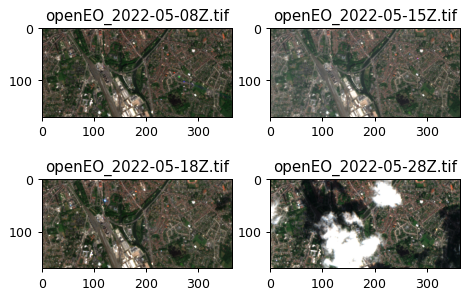

In [12]:
fig, axes = plt.subplots(figsize=(6, 4), nrows=2, ncols=2, dpi=90)
for i, path in enumerate(sorted(pathlib.Path("output/batch_job/").glob("*tif"))[:4]):
    data = rasterio.open(path).read()
    ax = axes[i // 2, i % 2]
    ax.imshow((data.transpose(1, 2, 0) / 3000).clip(0, 1))
    ax.set_title(path.name)